In [40]:
# Import des modules nécessaires et définition de fonctions pour tracer les courbes
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sklearn.linear_model import LinearRegression
from IPython.display import display, Markdown

def plotIt(x,y, title="sortie", xlab="X", ylab="Y"):
    fig, ax = plt.subplots()
    ax.plot(x, y)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, which='both')

    seaborn.despine(ax=ax, offset=0)

def plotScat(x,y, title="sortie", xlab="X", ylab="Y"):
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, which='both')

    seaborn.despine(ax=ax, offset=0)

def plotIt2(x1,y1,x2,y2,title="sortie", xlab="X", ylab="Y", legends=""):
    fig, ax = plt.subplots()
    ax.plot(x1, y1, x2,y2)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, which='both')
    ax.legend(legends)

    seaborn.despine(ax=ax, offset=0)

def plotIt2s(x1,y1,x2,y2,title="sortie", xlab="X", ylab="Y", legends=""):
    fig, ax = plt.subplots()
    ax.plot(x1, y1,'rx')
    ax.plot(x2, y2)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_title(title)
    ax.grid(True, which='both')
    ax.legend(legends)

    seaborn.despine(ax=ax, offset=0)

# a=np.arange(0,10,0.1)
# b=a**2
# plotIt(a,b, title="test")

Linéarisation d'un sonde de température NTC
===========================================

La linéarisation d'une caractéristique consiste à calculer l'équation de la tangente à la courbe autour d'un point donné. Le cas échéant, l'inversion de la courbe est plus simple.

## Exemple avec une thermo-résistance NTC

La caractéristique de la sonde NTC est donnée par une relation de la forme suivante :

$$
R(T) = R_0 \left( e^{\beta ( {1 \over T} - {1 \over {T_0}}) } \right)
$$

**Attention :** Les températures sont exprimées en Kelvin !

Le coefficient $\beta$ peut être calculé pour deux points connus d'une sonde par la relation

$$
\beta = \frac{T_1 \cdot T_2}{T_2-T_1} \cdot \ln{\left(\frac{R_1}{R_2}\right)}
$$

En pratique, le coefficient $\beta$ est donné par le fabricant pour une plage de température donnée. (cf. datasheet NTCS0603)

## Courbe de la thermorésistance

Pour tracer la courbe de la thermorésistance, on définit la relation et on calcule la valeur de la résistance pour une plage de températures.

In [41]:
def Rntc(T, T0, R0, B):
    K0=273
    Tk=T+K0
    T0k=T0+K0
    return R0*np.exp(B*(1/Tk-1/T0k))
    

In [42]:
vBETA=3965
vR0=10000
vT0=25
vRho0=1.29

# Définition d'une plage de température et calcul des valeurs de résistance.
vT=np.arange(-20, 70, 0.1)
vRt = Rntc(vT, T0=vT0, R0=vR0, B=vBETA)

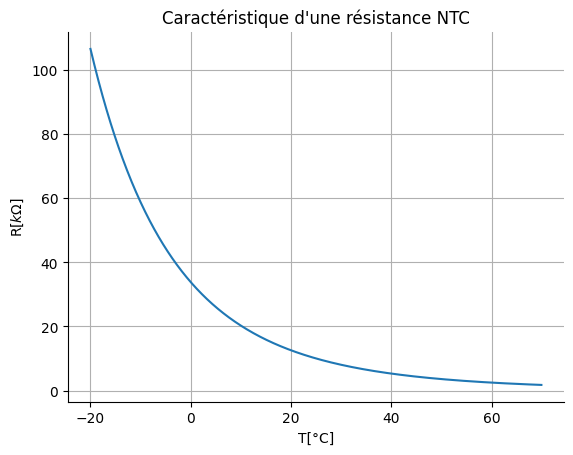

In [43]:
plotIt(vT,vRt/1000, xlab="T[°C]", ylab="R[$k\Omega$]", title="Caractéristique d'une résistance NTC")
# plt.savefig("../images/caracteristiqueNTC.png")

## Linéarisation


On veut linéariser cette caractéristique autour de 20°C en utilisant la *tangente*. On part de la relation qui donne la valeur de la résistance comme fonction de la température. 

On utilise *sympy* pour nous aider à résoudre le problème. La fonction qui nous intéresse peut être définie algébriquement comme suit :

In [44]:
import sympy as sp
T, T0, R0, B = sp.symbols('T T0 R0 B')
eqR = R0*sp.exp(B*(1/T-1/T0))

In [45]:
eqR

R0*exp(B*(-1/T0 + 1/T))

Pour faire une linéarisation, on calcule la pente de la courbe à un point de la courbe. Les valeurs proches peuvent être calculées avec une relation de la forme ci-dessous.
$$
y = f(x), \quad y_{lin} = f(x_0) + S \cdot (x-x_0),
\quad
S = \frac {d f(m)}{dm} \bigg|_{m_0}
$$
$S$ est la pente de la fonction à un point $x0$.

Le module *sympy* permet de trouver la dérifée d'une expression assez simplement. 

- On obtient la dérivée de la fonction qu'on a définit *eqR* avec l'expression *eqR.diff(T)*
- On peut évalue la valeur du résultat avec *res.subs(variable, valeur)*. Pour remplacer plusieurs valeurs, il suffit d'itérer (res.subs().subs()...)

### EX1 : Calculez la fonction linéarisée $y_{lin}$ autour d'un point T = 25 °C.

## Solution

In [46]:
dR=eqR.diff(T)

In [47]:
dR

-B*R0*exp(B*(-1/T0 + 1/T))/T**2

In [48]:
K0=273.15
vT1=25
valeurs={B:vBETA, T0:vT0+K0, R0:vR0, T:vT1+K0}
S20=dR.subs(valeurs)
R20=eqR.subs(valeurs)
print("Equation linéaire : R = {} + {} * (T-{})".format(R20,S20, vT1))

Equation linéaire : R = 10000.0000000000 + -446.039750578846 * (T-25)


Fonction linéarisée

In [49]:
def Rntc_lin(T):
    return R20 + S20*(T-vT1)

In [50]:
Rntc_lin(20)

12230.1987528942

### EX2 : Tracez la nouvelle fonction sur un graphique avec la caractéristique de la résistance NTC

## Solution

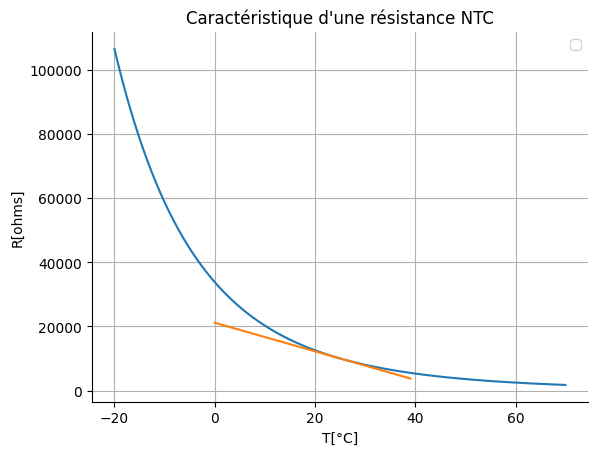

In [51]:
vTl=np.arange(0,40)
vRl=Rntc_lin(vTl)
plotIt2(vT,vRt, vTl, vRl, xlab="T[°C]", ylab="R[ohms]", title="Caractéristique d'une résistance NTC")

### EX2.2 : Quelle est l'erreur maximum sur une plage de 20 à 30°C ?

In [74]:
vT2=0
# Calcul de la différence de valeur de résistance calculée par la fonction
vR=Rntc(vT2, T0=vT0, R0=vR0, B=vBETA)
vRlin=Rntc_lin(vT2)
[vR, vRlin, vR-vRlin, (vR-vRlin)/vR*100]

[33819.09180370368, 21150.9937644712, 12668.0980392325, 37.4584217481712]

In [53]:
Rntc(30, T0=25, R0=1000, B=3170)

839.0057761304375

In [54]:
Rntc_lin(30)

7769.80124710577

## EX3 : Circuit de lecture

### Source de courant

In [83]:
I=0.25e-3 # 0.25 mA
Unl=np.array([Rntc(0,T0=vT0, R0=vR0, B=vBETA), Rntc(25,T0=vT0, R0=vR0, B=vBETA)])*I # Tension 
Ulin=np.array([Rntc_lin(0), Rntc_lin(25)])*I
print("U Non linérarisé",Unl,"[V]")
print("U Linéarisé",Ulin,"[V]")

U Non linérarisé [8.45477295 2.5       ] [V]
U Linéarisé [5.28774844111779 2.50000000000000] [V]


In [81]:
# Avec résistance et source de tension
# U = Rntc/(Rup+Rntc)*U
U=10
Rup=30000
Rnl=np.array([Rntc(0,T0=vT0, R0=vR0, B=vBETA), Rntc(25,T0=vT0, R0=vR0, B=vBETA)])
Rlin=np.array([Rntc_lin(0), Rntc_lin(25)])
Unl=Rnl/(Rnl+Rup)*U # Tension 
Ulin=Rlin/(Rlin+Rup)*U
print("U Non linérarisé",Unl,"[V]")
print("U Linéarisé",Ulin,"[V]")

Non linérarisé [5.29921233 2.5       ]
Linéarisé [4.13501130825778 2.50000000000000]


### EX4 : Calculez quelle sera l'erreur d'estimation de la température si on utilise la courbe linéarisée inverse au lieu de la caractéristique réelle

In [55]:
Rntc

<function __main__.Rntc(T, T0, R0, B)>

In [56]:
Rm=sp.Symbol('Rm')
Tr=sp.solve(eqR-Rm,T)

In [57]:
Tr

[B/log(Rm*exp(B/T0)/R0)]

In [58]:
Tlin=Tr[0].subs(Rm,756).subs(T0,25+K0).subs( R0,1000).subs(B,3170)-K0
print("La fonction linéarisée donnera {:.1f} °C pour une température réelle de 30 °C. L'erreur d'estimation sera de {:.1f} °C.".format(Tlin, Tlin-30))

La fonction linéarisée donnera 33.1 °C pour une température réelle de 30 °C. L'erreur d'estimation sera de 3.1 °C.


### EX5 : Comment réduire l'erreur due à la fonction de linéarisation ?

### Solution

On pourrait ajouter un petit offset pour équilibrer l'erreur.

### EX6: Le capteur est alimenté par un courant constant de 0.25mA. 
- Quelle est la tension à ses bornes pour 25° selon la relation non linéaire
- Quelle est la  tension à ses bornes pour la relation linéarisée

In [59]:
vT2=25
courant = 0.25e-3
# Calcul de la différence de valeur de résistance calculée par la fonction
vR=Rntc(vT2, T0=vT0, R0=vR0, B=vBETA)
vRlin=Rntc_lin(vT2)
np.array([vR, vRlin])*courant

array([2.5, 2.50000000000000], dtype=object)

In [60]:
vT2=0
courant = 0.25e-3
# Calcul de la différence de valeur de résistance calculée par la fonction
vR=Rntc(vT2, T0=vT0, R0=vR0, B=vBETA)
vRlin=Rntc_lin(vT2)
np.array([vR, vRlin])*courant

array([8.454772950925921, 5.28774844111779], dtype=object)

Modification du circuit pour générer le courant avec une source de tension et une résistance.

In [61]:
Rs=30e3
U0=10
vT2=0

vR=Rntc(vT2, T0=vT0, R0=vR0, B=vBETA)
vRlin=Rntc_lin(vT2)
Rtot=vR+Rs
Rtot_lin=vRlin+Rs

i=U0/Rtot
UR=i*vR

i_lin=U0/Rtot_lin
UR_lin=i_lin*vRlin
[UR, UR_lin]

[5.299212327828993, 4.13501130825778]

### Linéarisation 

En partant de la relation R=f(T) pour une résistance NTC, quelle serait la courbe qui comporte le moins d'erreur ?

Comment la calculer ?



In [62]:
vBETA=3965
vR0=10000
vT0=25
vRho0=1.29

# Définition d'une plage de température et calcul des valeurs de résistance.
vT=np.arange(0, 40, 0.1)
vRt = Rntc(vT, T0=vT0, R0=vR0, B=vBETA)

In [63]:
def linRsegment(T,a,b):
    return a*T+b

In [64]:
# R=a*T+b
vT=np.arange(0,40)
Rt = Rntc(vT, T0=vT0, R0=vR0, B=vBETA)

def toMinimize(ab):
    
    eR = np.max(np.abs(Rt-linRsegment(vT,ab[0],ab[1])))
    return eR


In [65]:
import scipy as sp

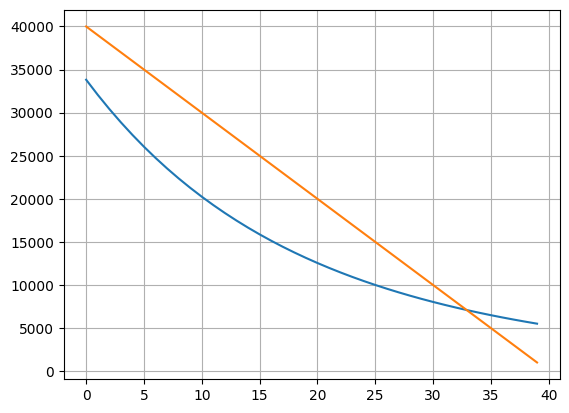

In [66]:
linR=linRsegment(vT,-1000,40000)
plt.plot(Rt)
plt.plot(linR)
plt.grid()

In [67]:
toMinimize([-885,40000])

11032.438686321624

In [68]:
eTab=Rt-linRsegment(vT,-7.260e+02,2.98e+04)
eR = np.max(np.abs(eTab))
eR

4019.0918037036827

In [69]:
res=sp.optimize.minimize(toMinimize, [-1000,40000], method="Nelder-Mead")

In [70]:

res

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 3534.441492594444
             x: [-7.260e+02  3.028e+04]
           nit: 83
          nfev: 156
 final_simplex: (array([[-7.260e+02,  3.028e+04],
                       [-7.260e+02,  3.028e+04],
                       [-7.260e+02,  3.028e+04]]), array([ 3.534e+03,  3.534e+03,  3.534e+03]))

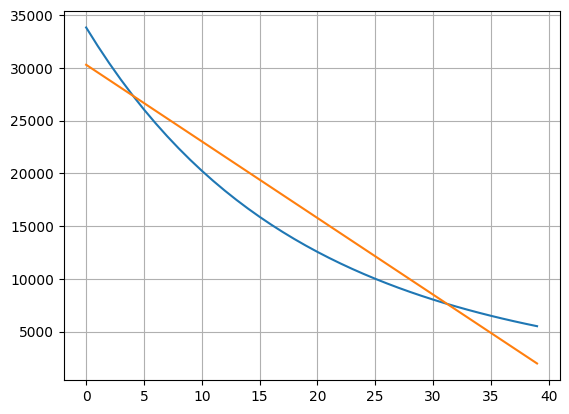

In [71]:
linR=linRsegment(vT,res.x[0], res.x[1])
plt.plot(Rt)
plt.plot(linR)
plt.grid()